## Simulation system

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Početni parametri

In [29]:
# Simulation parameters
num_points = 3 * 30 * 24 * 60  # 3 months of data, assuming 30 days per month
anomaly_chance = np.random.uniform(0.00005, 0.00012)  # [0.005-0.012]% chance of an anomaly
times = pd.date_range(start="2024-04-20", periods=num_points, freq='T')

# Anomaly counter
anomalies = 0

### Generiranje podataka

In [40]:
# Initialize sensors
accelerometer = np.zeros((num_points, 3))
gyroscope = np.zeros((num_points, 3))
magnetometer = np.zeros((num_points, 3))
temperature = np.full(num_points, 37)
pressure = np.full(num_points, 100)
light = np.full(num_points, 100)
behavior = np.full(num_points, "resting")

# Define behavior probabilities and transitions
curr_behavior = "resting"
behavior_duration = 0
time_since_last_change = 0
sleep_start_time = np.random.randint(18 * 60, 24 * 60)  # Sleep can start between 6pm and 12am
sleep_duration = np.random.randint(3 * 60, 4 * 60 + 1)  # Sleep duration between 3 and 4 hours in minutes

def daily_temperature_variation(hour, base_temp=20):
    # Simulate cooler temperatures at night and warmer during the day
    return base_temp + 10 * np.sin(np.pi * (hour - 6) / 12)

# Function to simulate daily light variation
def daily_light_variation(hour):
    # Light intensity peaks at noon and is zero at night
    return max(0, 1000 * np.sin(np.pi * (hour - 6) / 18))

# Function to simulate daily pressure variation
def daily_pressure_variation(hour, base_pressure=1013):
    # Slight fluctuation in pressure throughout the day
    return base_pressure + 5 * np.sin(np.pi * (hour - 6) / 12)

for i in range(1, num_points):
    current_minute = i % 1440  # Current minute in the day
    current_hour = current_minute // 60 # Current hour in the day

    temperature[i] = daily_temperature_variation(current_hour)
    light[i] = daily_light_variation(current_hour)
    pressure[i] = daily_pressure_variation(current_hour)

    # Check if it's time to sleep
    if sleep_start_time <= current_minute < sleep_start_time + sleep_duration:
        curr_behavior = "sleeping"
    else:
        if behavior_duration <= 0:
            change_probability = 0.05 + 0.001 * time_since_last_change
            if np.random.random() < change_probability:
                possible_behaviors = ["running", "walking", "resting"]
                if curr_behavior in possible_behaviors:
                    possible_behaviors.remove(curr_behavior)  # Remove current behavior from the list if it exists
                curr_behavior = np.random.choice(possible_behaviors)
                min_behavior_duration = {"running": 10, "walking": 20, "resting": 30}[curr_behavior]
                behavior_duration = np.random.randint(min_behavior_duration, min_behavior_duration + 20)
                time_since_last_change = 0
        else:
            behavior_duration -= 1
            time_since_last_change += 1


    # Sensor data generation based on behavior
    if curr_behavior == "running":
        accelerometer[i] = accelerometer[i-1] + np.random.normal(5, 2, 3)
        gyroscope[i] = gyroscope[i-1] + np.random.normal(300, 50, 3)
        magnetometer[i] = magnetometer[i-1] + np.random.normal(0, 0.1, 3)
        behavior[i] = "running"
    elif curr_behavior == "walking":
        accelerometer[i] = accelerometer[i-1] + np.random.normal(1, 0.5, 3)
        gyroscope[i] = gyroscope[i-1] + np.random.normal(100, 20, 3)
        magnetometer[i] = magnetometer[i-1] + np.random.normal(0, 0.05, 3)
        behavior[i] = "walking"
    elif curr_behavior == "resting":
        accelerometer[i] = accelerometer[i-1] + np.random.normal(0, 0.1, 3)
        gyroscope[i] = gyroscope[i-1] + np.random.normal(0, 5, 3)
        magnetometer[i] = magnetometer[i-1] + np.random.normal(0, 0.02, 3)
        behavior[i] = "resting"
    elif curr_behavior == "sleeping":
        accelerometer[i] = np.random.normal(0, 0.05, 3)
        gyroscope[i] = np.random.normal(0, 1, 3)
        magnetometer[i] = np.random.normal(0, 0.01, 3)
        behavior[i] = "sleeping"

# Remove the first row of data from each sensor array and the behavior array
accelerometer = accelerometer[1:]
gyroscope = gyroscope[1:]
magnetometer = magnetometer[1:]
temperature = temperature[1:]
pressure = pressure[1:]
light = light[1:]
behavior = behavior[1:]
times = times[1:]

### Anomalije

In [19]:
# Introducing anomalies with variable lengths

for _ in range(int(num_points * anomaly_chance)):
    start = np.random.randint(0, num_points)
    duration = np.random.randint(30, int(1.5 * 24 * 60))  # From 30 minutes to 1.5 days (in minutes)
    end = min(start + duration, num_points)

    # Randomly choose which sensors will have anomalies
    sensors = ['accelerometer', 'gyroscope', 'magnetometer', 'temperature', 'pressure', 'light']
    num_sensors_affected = np.random.choice([1, 2], p=[0.8, 0.2])  # 80% chance for 1 sensor, 20% for 2 sensors
    affected_sensors = np.random.choice(sensors, size=num_sensors_affected, replace=False)

    if 'accelerometer' in affected_sensors:
        accelerometer[start:end] += np.random.normal(2, 1, (end - start, 3))
    if 'gyroscope' in affected_sensors:
        gyroscope[start:end] += np.random.normal(300, 50, (end - start, 3))
    if 'magnetometer' in affected_sensors:
        magnetometer[start:end] += np.random.normal(100, 20, (end - start, 3))
    if 'temperature' in affected_sensors:
        temperature[start:end] += np.random.normal(10, 2, end - start)
    if 'pressure' in affected_sensors:
        pressure[start:end] += np.random.normal(15, 5, end - start)
    if 'light' in affected_sensors:
        light[start:end] = 0

    print("Hours of anomaly: ", (duration)/24)
    anomalies += 1

Hours of anomaly:  31.458333333333332


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

### Izrada DataFrame-a

In [43]:
# Print the number of anomalies
print(f"Number of anomalies: {anomalies}")

# Create DataFrame
df = pd.DataFrame({
    'Accelerometer_X': accelerometer[:, 0],
    'Accelerometer_Y': accelerometer[:, 1],
    'Accelerometer_Z': accelerometer[:, 2],
    'Gyroscope_X': gyroscope[:, 0],
    'Gyroscope_Y': gyroscope[:, 1],
    'Gyroscope_Z': gyroscope[:, 2],
    'Magnetometer_X': magnetometer[:, 0],
    'Magnetometer_Y': magnetometer[:, 1],
    'Magnetometer_Z': magnetometer[:, 2],
    'Temperature': temperature,
    'Pressure': pressure,
    'Light': light,
    'Time': times,
    'Behavior': behavior
}, index=times-1)

Number of anomalies: 0


TypeError: Addition/subtraction of integers and integer-arrays with DatetimeArray is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

### Prikazivanje podataka

       Accelerometer_X  Accelerometer_Y  Accelerometer_Z    Gyroscope_X  \
count    129600.000000    129600.000000    129600.000000  129600.000000   
mean       1132.846693      1132.191151      1131.843932   76726.268650   
min          -1.047863        -1.363326        -2.327763    -104.984647   
25%         484.673330       483.443423       484.385313   33422.327986   
50%        1134.564450      1132.334250      1133.308232   76823.747556   
75%        1716.397593      1711.054364      1716.554683  116589.027860   
max        3173.323334      3138.820192      3186.728315  203866.755823   
std         735.644570       735.695091       735.131300   49169.536862   

         Gyroscope_Y    Gyroscope_Z  Magnetometer_X  Magnetometer_Y  \
count  129600.000000  129600.000000   129600.000000   129600.000000   
mean    76742.757935   76666.730660        0.251077       -0.022101   
min       -81.098599     -90.313056       -5.025214       -6.633649   
25%     33674.079557   33517.065304     

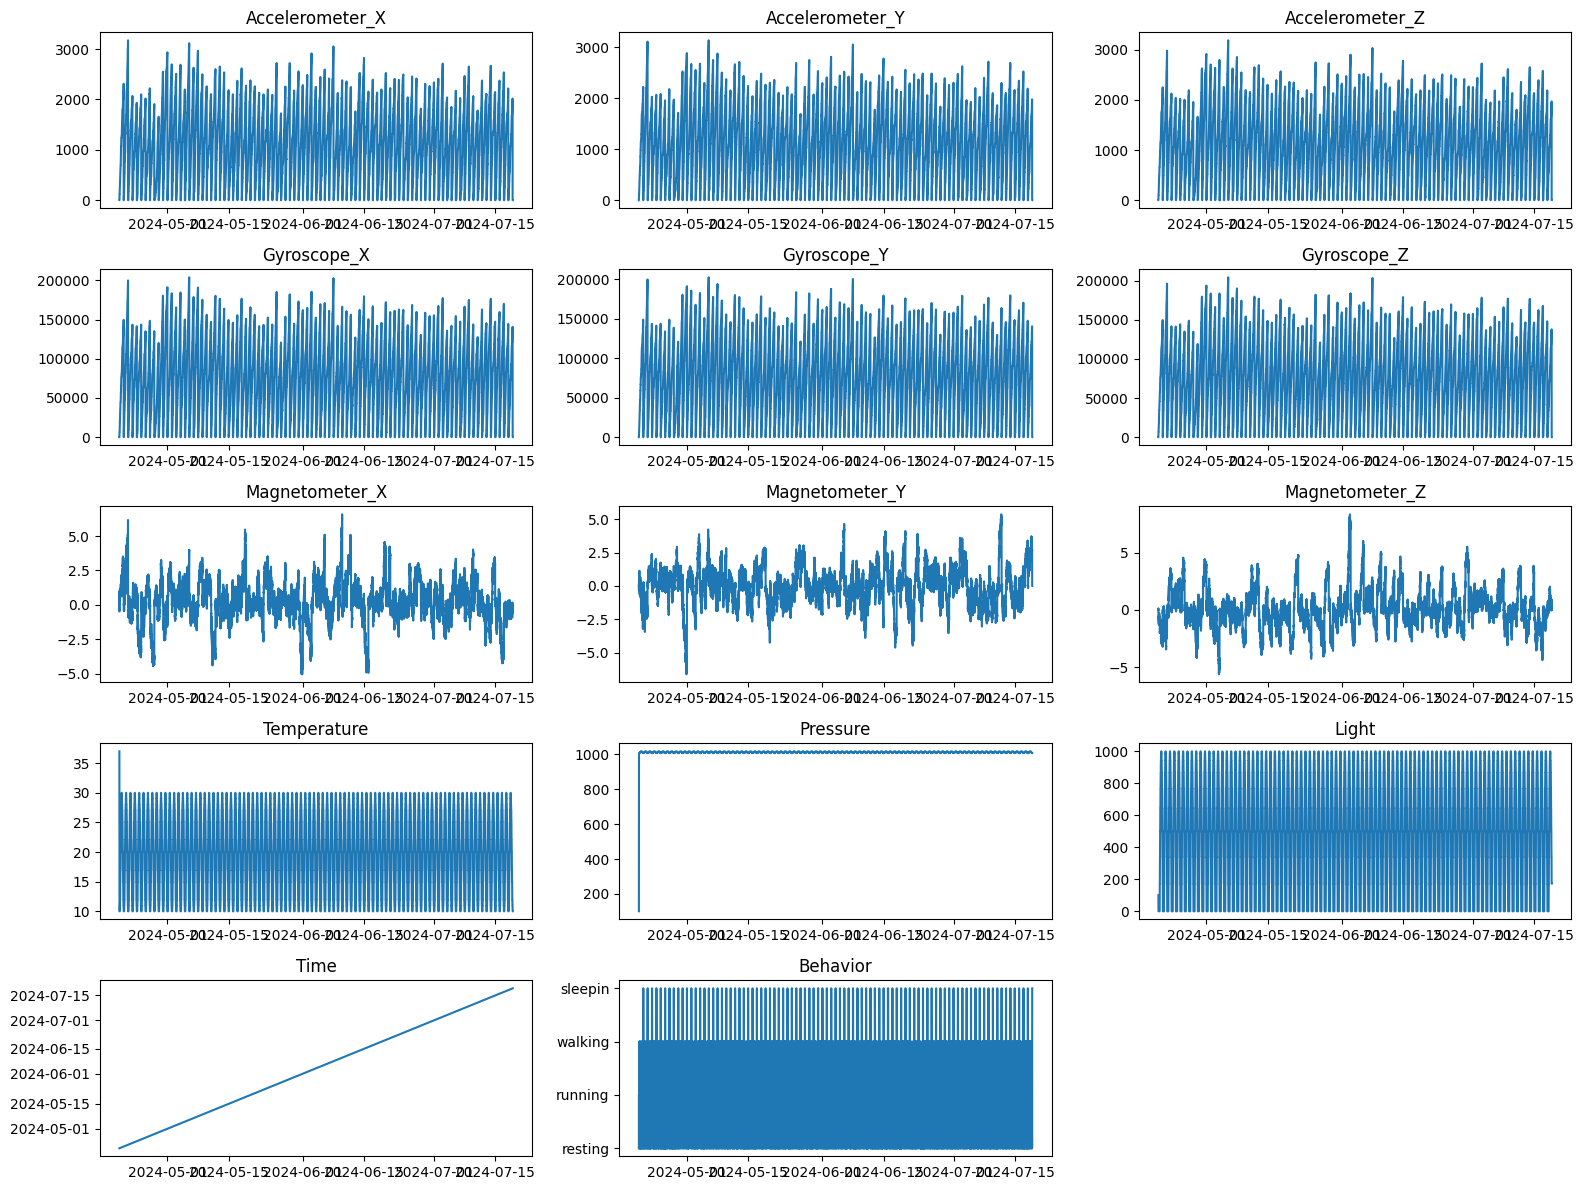

In [32]:
# Displaying statistical summary of the data
print(df.describe())

# Displaying the data
plt.figure(figsize=(16, 12))
for i, column in enumerate(df.columns):
    plt.subplot(5, 3, i + 1)
    plt.plot(df.index, df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

### Spremanje podataka u CSV datoteku

In [23]:
# Sava data to CSV file
df.to_csv('sensor_data.csv')